<a href="https://colab.research.google.com/github/gastong47/FinalProject/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FINAL PROJECT 

## 1.Importing and Installing relevant packages / libraries

In [ ]:
# Import all relevant libraries to start our project
import os, shutil, pathlib, keras, matplotlib.pyplot as plt 
from tensorflow.keras.layers import BatchNormalization, SeparableConv2D, Activation, GlobalAveragePooling2D

from google.colab import files, drive

!pip install split-folders
import splitfolders

import tensorflow as tf

from tensorflow.keras.utils import image_dataset_from_directory

import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Rescaling, Dropout, BatchNormalization, add

!pip install keras-tuner -q
import keras_tuner as kt 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.4 MB/s eta 0:00:00


## 2.Gathering Datasets & Preprocessing

### 2.1 Downloading Datasets using kaggle's API

In [ ]:
# install the Kaggle API client
!pip install kaggle

# upload the API key file to Google Colab
uploaded = files.upload()


# copy the API key file to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# set the permissions for the API key file
!chmod 600 ~/.kaggle/kaggle.json

# download the dataset from Kaggle
!kaggle datasets download -d sachinkumar413/covid-pneumonia-normal-chest-xray-images

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json
 99% 276M/277M [00:14<00:00, 20.5MB/s]
100% 277M/277M [00:14<00:00, 20.2MB/s]


In [ ]:
# download our second dataset
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia

100% 2.05G/2.06G [01:39<00:00, 23.4MB/s]
100% 2.06G/2.06G [01:39<00:00, 22.2MB/s]


In [ ]:
# unzip the downloaded files
!unzip -qq covid-pneumonia-normal-chest-xray-images.zip

In [ ]:
!unzip -qq chest-xray-covid19-pneumonia

For Convienience we move unziped folrders into a single folder

In [ ]:
import os, shutil, pathlib
os.mkdir('/content/covid-pneumonia-normal-chest-xray-images')

# move the directories inside the new directory
for directory in ['COVID', 'NORMAL', 'PNEUMONIA']:
  shutil.move('/content/' + directory, '/content/covid-pneumonia-normal-chest-xray-images' )

### 2.2 Spliting Data into Training, Validation and Test Data

Sliptting the data 

In [ ]:
originalDir = pathlib.Path("/content/covid-pneumonia-normal-chest-xray-images")
newDir = pathlib.Path("CovidDataset1")  

Splitting first Dataset 1 

In [ ]:
# Split first dataset into relevant directories
splitfolders.fixed(originalDir,
                    output= newDir,
                    seed=42, 
                    fixed=(700, 300, 625), 
                    oversample=False, 
                    group_prefix=None, 
                    move=False) 

Copying files: 4875 files [00:01, 3140.01 files/s]


A simple counter to check our splits are good 

In [ ]:
counter = 0
for file in enumerate(os.listdir("/content/CovidDataset1/train/COVID")):
  counter += 1
print (counter)

700


### 2.3 Data Preprocessing 


Reformatting the data from PNG files into floating-point tensors for the model requires the following steps:

- Read in the image files.
- Decode the images into pixel grids of RGB values.
- Convert them to floating-point tensors.
- Reshape them to the same size (180 x 180).
- Batch them together (using batches of 32 images).

To this end we will use image_dataset_from_directory() method from keras, which will create and return a tf.data.Dataset object configured to read the files, shuffle them, resize them to our specified size, and group them into batches.

The newly created tensors are stored in the appropriately called variables: tDataset for training, vDataset for validation and testDataset for testing. After that we retrieve and print data and label shape in order to make sure everything is looking good.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
#generate datasets using image_dataset_from_directory on different directories
tDataset = image_dataset_from_directory('/content/CovidDataset1/train', image_size=(180,180), batch_size=32, label_mode = 'categorical')
vDataset = image_dataset_from_directory('/content/CovidDataset1/val', image_size=(180,180), batch_size=32, label_mode = 'categorical')
testDataset = image_dataset_from_directory('/content/CovidDataset1/test', image_size=(180,180), batch_size=32, label_mode = 'categorical')



Found 2100 files belonging to 3 classes.
Found 900 files belonging to 3 classes.
Found 1875 files belonging to 3 classes.


In [ ]:
# iterate over data and labels to make sure they are the correct shape
for batch, labels, in tDataset:
  print('Data Shape:', batch.shape)
  print('Labels shape', labels.shape)
  break 

Data Shape: (32, 180, 180, 3)
Labels shape (32, 3)


### 2.4 Data Augmentation

We define a simple augmentation sequence in order to invoke it inside our models to increase variety and reduce overfitting.

In [ ]:
#define sequential model using keras pre built augmentation layers
augmentation = keras.Sequential(
    [
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.1),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomFlip("vertical")
    ]
)

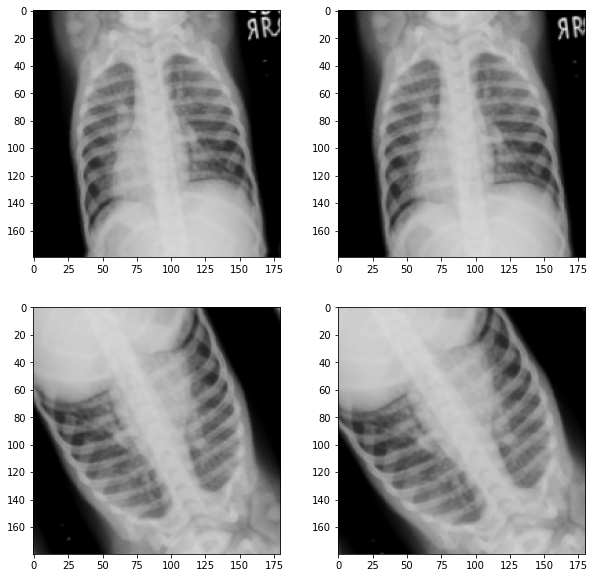

In [ ]:
plt.figure(figsize=(10, 10)) 
for img, _ in tDataset.take(1):                           
    for i in range(4):
        augImages = augmentation(img)              
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(augImages[0].numpy().astype("uint8")) 


## 3.Building our Baseline Model


Here the CNN baseline classifier model is defined. It is a sequential model, first the augmentation layers and rescalling are invoked  to preprocess the data coming through the model. A sequence of just one convolutional layer with max pooling, followed by a flattening layer, a fully connected dense layer of 3 units and softmax activation. The number of filters in the convolutional layer is 32, kernel size is 3 by 3 and the activation function is “relu”. The model is compiled with the categorical cross-entropy loss function and the Adam optimization algorithm. The chosen metrics are also invoked.


In [ ]:

# define the model
model = Sequential()
model.add(augmentation)
model.add(Rescaling(1./255))


# add convolutional layers
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# add a flattening layer
model.add(Flatten())

## add the output layer, since we’ll do multinomial classification we end the model with a Dense layer of three units and softmax activation

model.add(Dense(units=3, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy', 'Precision', 'Recall'])

### 3.1 Fitting baseline model using Callbacks

We'll employ a ModelCheckpoint callback to save the model after each epoch. We'll specify the file save location, as well as two arguments: `save_best_only=True` and `monitor="val_loss"`. This tells the callback to only save a new file, when the value of the `val_loss` metric is better than the lowest value recorded during training.

This saves us from having to retrain the model to its optimum stage if we run into overfitting 

In [ ]:
import keras 

# we use .ModelCheckpoint to save the best model as a keras object
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="baselineModel.keras",
        save_best_only = True,
        monitor = 'val_loss')
]
# we proceed to fit the model and assign it to history variable
history = model.fit(
    tDataset, 
    epochs = 100,
    validation_data = vDataset,
    callbacks = callbacks
)

Epoch 1/100
66/66 [==============================] - 17s 106ms/step - loss: 2.7168 - accuracy: 0.5524 - precision: 0.5780 - recall: 0.4624 - val_loss: 0.5110 - val_accuracy: 0.7744 - val_precision: 0.7953 - val_recall: 0.7467
Epoch 2/100
66/66 [==============================] - 7s 95ms/step - loss: 0.5598 - accuracy: 0.7733 - precision: 0.7991 - recall: 0.7348 - val_loss: 0.4829 - val_accuracy: 0.7767 - val_precision: 0.7959 - val_recall: 0.7711
Epoch 3/100
66/66 [==============================] - 7s 99ms/step - loss: 0.5281 - accuracy: 0.7743 - precision: 0.7925 - recall: 0.7457 - val_loss: 0.4100 - val_accuracy: 0.8333 - val_precision: 0.8409 - val_recall: 0.8222
Epoch 4/100
66/66 [==============================] - 7s 97ms/step - loss: 0.4574 - accuracy: 0.8210 - precision: 0.8416 - recall: 0.8019 - val_loss: 0.3786 - val_accuracy: 0.8533 - val_precision: 0.8663 - val_recall: 0.8422
Epoch 5/100
66/66 [==============================] - 7s 97ms/step - loss: 0.4275 - accuracy: 0.8343 - 

### 3.2 Plotting Training Metrics 

To make things easier down the line we define a helper function that will allow us to plot tranining and validation accuracy and loss for this and future models

In [ ]:
# define a function to plot the training and validation accuracy and loss
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
    

    plt.plot(epochs, acc, 'ro', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()

    plt.plot(epochs, loss, 'ro', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()

    plt.show()

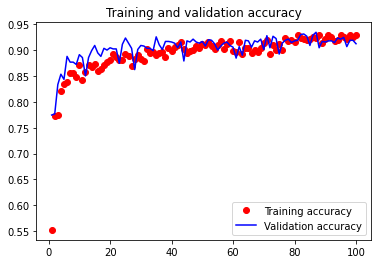

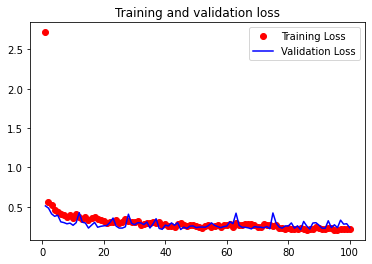

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_training(history)

### 3.3 Evaluation Model On the Test Set


In [ ]:
testModel = keras.models.load_model('/content/baselineModel.keras')
tLoss, tAcc, tPres, tRecall = testModel.evaluate(testDataset)
print(f'Test Accuracy:{tAcc:3f}')
print(f'Test Precission:{tPres:3f}')
print(f'Test Recall:{tRecall:3f}')



59/59 [==============================] - 3s 41ms/step - loss: 0.2175 - accuracy: 0.9349 - precision: 0.9348 - recall: 0.9328
Test Accuracy:0.934933
Test Precission:0.934794
Test Recall:0.932800


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 253472)            0         
                                                                 
 dense (Dense)               (None, 3)                 760419    
                                                      

We can see that despite the model been extremely simple it is fast to achieve a very good performance, despite this, the performance on the test set is not stellar.  We will address this issue by slightly increasing the model's complexity and using Dropout.

## 4.Second Model

If we use the current data augmentation setup to train a new model, our model won't be exposed to the same input multiple times, although the inputs it does see are highly correlated as they are taken from a small set of original images. This may not be enough to tackle overfitting. To prevent it, we should add a Dropout layer before the densely-connected classifier. This will constitute our second, slightly improved Model.

In [ ]:
from tensorflow.keras.layers import Dropout
# define the model
model2 = Sequential()
model2.add(augmentation)
model2.add(Rescaling(1./255))

# add convolutional blocks
model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

# Here we add two extra convolutional blocks
model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

# add a flattening layer
model2.add(Flatten())

# Dropout allows us to prevent overfitting by rondomly disactivating some neurons
model2.add(Dropout(0.4))

#add the output layer, since we’ll do multinomial classification we end the model with a Dense layer of three units and softmax activation
model2.add(Dense(units=3, activation='softmax'))

# compile the model
model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy', 'Precision','Recall'])

### Training

In [ ]:
callbacks2 = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'Model2.0.keras',
        save_best_only = True,
        monitor = 'val_loss'
    )
]

history2 = model2.fit(
    tDataset,
    epochs = 100,
    validation_data = vDataset,
    callbacks = callbacks2
)

Epoch 1/100
66/66 [==============================] - 13s 155ms/step - loss: 0.8732 - accuracy: 0.5876 - precision: 0.7199 - recall: 0.4210 - val_loss: 0.4772 - val_accuracy: 0.8244 - val_precision: 0.8303 - val_recall: 0.8156
Epoch 2/100
66/66 [==============================] - 13s 183ms/step - loss: 0.6142 - accuracy: 0.7448 - precision: 0.7732 - recall: 0.6995 - val_loss: 0.5082 - val_accuracy: 0.7844 - val_precision: 0.7968 - val_recall: 0.7711
Epoch 3/100
66/66 [==============================] - 9s 139ms/step - loss: 0.5325 - accuracy: 0.7876 - precision: 0.8085 - recall: 0.7600 - val_loss: 0.4498 - val_accuracy: 0.8156 - val_precision: 0.8212 - val_recall: 0.8011
Epoch 4/100
66/66 [==============================] - 13s 183ms/step - loss: 0.4490 - accuracy: 0.8310 - precision: 0.8433 - recall: 0.8148 - val_loss: 0.4104 - val_accuracy: 0.8400 - val_precision: 0.8435 - val_recall: 0.8322
Epoch 5/100
66/66 [==============================] - 11s 153ms/step - loss: 0.4284 - accuracy: 0.

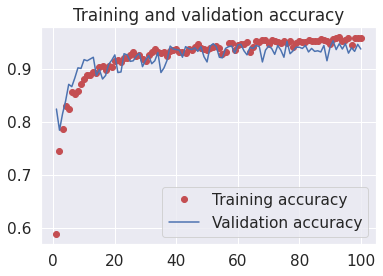

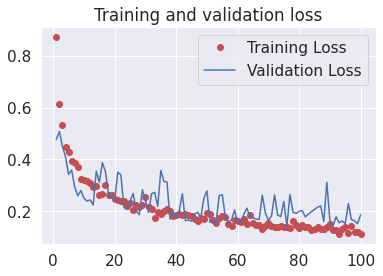

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_training(history2)

### Testing

In [ ]:
testModel = keras.models.load_model('/content/Model2.0.keras')
tLoss, tAcc, tPres, tRecall = testModel.evaluate(testDataset)
print(f'Test Accuracy:{tAcc:3f}')
print(f'Test Precission:{tPres:3f}')
print(f'Test Recall:{tRecall:3f}')

59/59 [==============================] - 4s 60ms/step - loss: 0.1754 - accuracy: 0.9413 - precision: 0.9428 - recall: 0.9413
Test Accuracy:0.941333
Test Precission:0.942842
Test Recall:0.941333


In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                  

## 5.Third Model

Our third iteration model, builds on the previous ones by adding an extra convolutional block and also increasing the number of filters in all blocks, ranging from 64 to 512. 

Also densly connected layers are stacked to form a classifier, instead of using just a single Dense layer of 3 units. 

In [ ]:
# define the model
model3 = Sequential()
model3.add(augmentation)
model3.add(Rescaling(1./255))

# add convolutional layers
model3.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))


model3.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

# add a flattening layer

model3.add(Flatten())
model3.add(Dropout(0.4))

## add the output layer, since we’ll do binary classification we end the model with a Dense layer of one unit and sigmoid activation
model3.add(Dense(48,activation="relu"))
model3.add(Dense(24,activation="relu"))
model3.add(Dense(6,activation="relu"))

model3.add(Dense(units=3, activation='softmax'))

# compile the model
model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'Precision','Recall'])

### Training

In [ ]:
callbacks3 = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'Model3.0.keras',
        save_best_only = True,
        monitor = 'val_loss'
    )
]

history3 = model3.fit(
    tDataset,
    epochs = 100,
    validation_data = vDataset,
    callbacks = callbacks3
)

Epoch 1/70
66/66 [==============================] - 14s 161ms/step - loss: 1.0616 - accuracy: 0.4033 - precision: 0.5147 - recall: 0.0919 - val_loss: 0.9329 - val_accuracy: 0.6056 - val_precision: 0.4876 - val_recall: 0.2189
Epoch 2/70
66/66 [==============================] - 9s 133ms/step - loss: 0.8244 - accuracy: 0.6700 - precision: 0.6877 - recall: 0.4571 - val_loss: 0.5333 - val_accuracy: 0.7767 - val_precision: 0.7921 - val_recall: 0.7533
Epoch 3/70
66/66 [==============================] - 9s 132ms/step - loss: 0.5309 - accuracy: 0.7752 - precision: 0.7891 - recall: 0.7500 - val_loss: 0.4719 - val_accuracy: 0.7900 - val_precision: 0.7970 - val_recall: 0.7767
Epoch 4/70
66/66 [==============================] - 9s 133ms/step - loss: 0.4559 - accuracy: 0.8210 - precision: 0.8302 - recall: 0.8010 - val_loss: 0.3789 - val_accuracy: 0.8778 - val_precision: 0.8853 - val_recall: 0.8489
Epoch 5/70
66/66 [==============================] - 9s 131ms/step - loss: 0.3837 - accuracy: 0.8490 - p

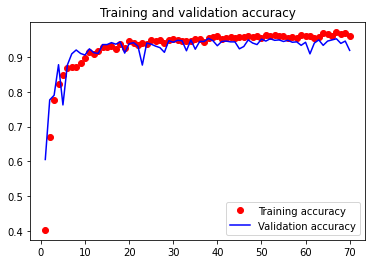

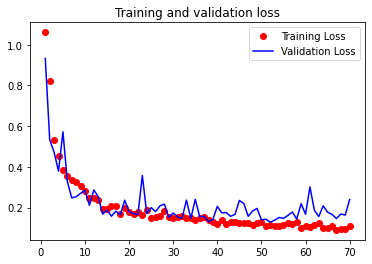

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_training(history3)

### Testing

In [ ]:
testModel = keras.models.load_model('/content/Model3.0.keras')
tLoss, tAcc, tPres, tRecall = testModel.evaluate(testDataset)
print(f'Test Accuracy:{tAcc:3f}')
print(f'Test Precission:{tPres:3f}')
print(f'Test Recall:{tRecall:3f}')

59/59 [==============================] - 4s 52ms/step - loss: 0.1593 - accuracy: 0.9531 - precision: 0.9536 - recall: 0.9525
Test Accuracy:0.953067
Test Precission:0.953550
Test Recall:0.952533


After training our third model, we can clearly see that adding complexity helps the models achieve better results. But the early signs of overfitting can be clearly spotted in the graph above. 

In ordder to asses the relative merits of the results we are obtaning, we will proceed to Fine Tune a state of the art model. 

## 6.Fine Tunning a Pre-Trained Model

### 6.1 Downloading EfficientNetv2 and freezing topmost layers

When training a deep learning model on a small image dataset, a popular and successful strategy is to use a model that has already been trained on a larger dataset. This 'pretrained model' is typically trained on a large-scale image-classification dataset.

Fine-tuning involves making small changes to the pre-existing, abstract representations of a model in order to make them more applicable for the specific task.


In [ ]:
base = keras.applications.EfficientNetV2B0(
        include_top = False,
        input_shape=(180,180,3),
        weights='imagenet'
)

24274472/24274472 [==============================] - 0s 0us/step


In [ ]:
base.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 180, 180, 3)  0           ['rescaling_3[0][0]']            
                                                                                                  
 stem_conv (Conv2D)             (None, 90, 90, 32)   864         ['normalization[0

We only want to train and thus alter the topmost layers since they are the ones filtering more specific features and thus might differ to a greater extent from the images on our dataset.

In [ ]:
base.trainable = True
for layer in base.layers[:-10]:
  layer.trainable = False

### 6.2 Combining Base model with Custom Classifier

Now we create a new model thata chains together our data augmentation module and our convolutional base from keras with some unfrozen layers to perform fine tuning.

In [ ]:
# define the model
model4 = Sequential()

# Apply the augmentation block for consistency
model4.add(augmentation)

# Invoke the base of the model as previously defined 
model4.add(base)

# add a flattening layer
model4.add(Flatten())

# densly connected layers are stacked to form our classifier,
model4.add(Dense(24,activation="relu"))
model4.add(Dense(6,activation="relu"))
#  output layer, since we’ll do multinomial classification we end the model with a Dense layer of three units and softmax activation
model4.add(Dense(units=3, activation='softmax'))

# compile the model
model4.compile(loss='categorical_crossentropy', 
               optimizer=keras.optimizers.RMSprop(learning_rate=1e-5), 
               metrics=['accuracy', 'Precision','Recall'])

### Training

In [ ]:
callbacks4 = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'FineTunedModel.keras',
        save_best_only = True,
        monitor = 'val_loss'
    )
]

history4 = model4.fit(
    tDataset,
    epochs = 100,
    validation_data = vDataset,
    callbacks = callbacks4
)

Epoch 1/100
66/66 [==============================] - 20s 170ms/step - loss: 0.9720 - accuracy: 0.4924 - precision: 0.6325 - recall: 0.2467 - val_loss: 0.7760 - val_accuracy: 0.6200 - val_precision: 0.7951 - val_recall: 0.5044
Epoch 2/100
66/66 [==============================] - 9s 135ms/step - loss: 0.7471 - accuracy: 0.7167 - precision: 0.8056 - recall: 0.4519 - val_loss: 0.5878 - val_accuracy: 0.8144 - val_precision: 0.8658 - val_recall: 0.5878
Epoch 3/100
66/66 [==============================] - 9s 137ms/step - loss: 0.5734 - accuracy: 0.8433 - precision: 0.8682 - recall: 0.6271 - val_loss: 0.4800 - val_accuracy: 0.8700 - val_precision: 0.8908 - val_recall: 0.7344
Epoch 4/100
66/66 [==============================] - 11s 163ms/step - loss: 0.4708 - accuracy: 0.8881 - precision: 0.9078 - recall: 0.8014 - val_loss: 0.3898 - val_accuracy: 0.9011 - val_precision: 0.9211 - val_recall: 0.8689
Epoch 5/100
66/66 [==============================] - 12s 171ms/step - loss: 0.3838 - accuracy: 0.9

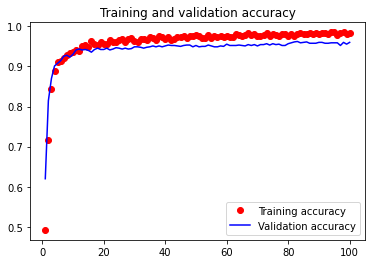

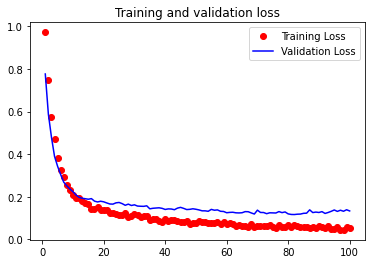

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_training(history4)

### Testing

In [ ]:
testModel = keras.models.load_model('/content/FineTunedModel.keras')
tLoss, tAcc, tPres, tRecall = testModel.evaluate(testDataset)
print(f'Test Accuracy:{tAcc:3f}')
print(f'Test Precission:{tPres:3f}')
print(f'Test Recall:{tRecall:3f}')

59/59 [==============================] - 6s 51ms/step - loss: 0.1158 - accuracy: 0.9675 - precision: 0.9685 - recall: 0.9664
Test Accuracy:0.967467
Test Precission:0.968466
Test Recall:0.966400


As we can see our model starts to overfit quite early on in its trainng, by epoch 18 validation loss and accuracy start to flatten out but training metrics keep improving. 

Despite this fact, the model achieves a very good performance in a short time 

## 7.Building up our own Xception like Model Using Latest Convnet Developments

###Model 5: Batch Normalization

Normalization is a way of making different samples seen by a machine learning model more similar to each other. Batch normalization is one type of normalization layer which helps to normalize data during training using the mean and variance of the current batch of data. During inference, it uses an average of the mean and variance observed during training. Some experiments appear to demonstrate that using batch normalization can actually result in more successful training outcomes. But its main purpose is to accelerate the training process.


In [ ]:
from tensorflow.keras.layers import BatchNormalization

# define the model
model5 = Sequential()
model5.add(augmentation)
model5.add(Rescaling(1./255))

# add convolutional layers
model5.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))


model5.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
model5.add(MaxPooling2D(pool_size=(2,2)))

# add a flattening layer and Dropout
model5.add(Flatten())
model5.add(Dropout(0.4))

# densly connected layers are stacked to form our classifier,
model5.add(Dense(48,activation="relu"))
model5.add(Dense(24,activation="relu"))
model5.add(Dense(6,activation="relu"))

model5.add(BatchNormalization())

#  output layer, since we’ll do multinomial classification we end the model with a Dense layer of three units and softmax activation
model5.add(Dense(units=3, activation='softmax'))

# compile the model
model5.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy', 'Precision','Recall'])

#### Training

In [ ]:
callbacks5 = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'AdvancedModel1.0.keras',
        save_best_only = True,
        monitor = 'val_loss'
    )
]

history5 = model5.fit(
    tDataset,
    epochs = 200,
    validation_data = vDataset,
    callbacks = callbacks5
)


Epoch 1/200
66/66 [==============================] - 12s 183ms/step - loss: 0.0595 - accuracy: 0.9752 - precision: 0.9771 - recall: 0.9738 - val_loss: 0.1898 - val_accuracy: 0.9367 - val_precision: 0.9367 - val_recall: 0.9367
Epoch 2/200
66/66 [==============================] - 12s 180ms/step - loss: 0.0554 - accuracy: 0.9838 - precision: 0.9843 - recall: 0.9829 - val_loss: 0.4027 - val_accuracy: 0.8722 - val_precision: 0.8740 - val_recall: 0.8711
Epoch 3/200
66/66 [==============================] - 12s 184ms/step - loss: 0.0619 - accuracy: 0.9814 - precision: 0.9814 - recall: 0.9810 - val_loss: 0.1522 - val_accuracy: 0.9478 - val_precision: 0.9499 - val_recall: 0.9478
Epoch 4/200
66/66 [==============================] - 12s 181ms/step - loss: 0.0660 - accuracy: 0.9786 - precision: 0.9790 - recall: 0.9781 - val_loss: 0.8708 - val_accuracy: 0.7044 - val_precision: 0.7258 - val_recall: 0.6911
Epoch 5/200
66/66 [==============================] - 12s 181ms/step - loss: 0.0841 - accuracy: 0

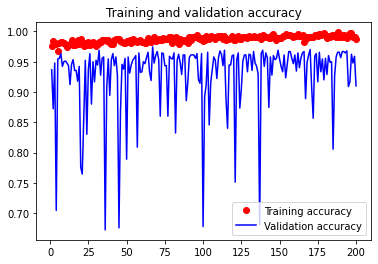

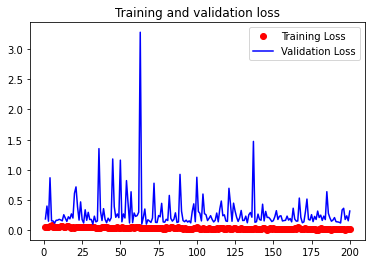

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_training(history5)

#### Testing

In [ ]:
testModel = keras.models.load_model('/content/AdvancedModel1.0.keras')
tLoss, tAcc, tPres, tRecall = testModel.evaluate(testDataset)
print(f'Test Accuracy:{tAcc:3f}')
print(f'Test Precission:{tPres:3f}')
print(f'Test Recall:{tRecall:3f}')

59/59 [==============================] - 3s 45ms/step - loss: 1.1377 - accuracy: 0.9632 - precision: 0.9637 - recall: 0.9621
Test Accuracy:0.963200
Test Precission:0.963675
Test Recall:0.962133


In [ ]:
files.download('/content/AdvancedModel1.0.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Model 6 Depthwise separable convolutions and increasing depth 

Depthwise separable convolution is a type of convolutional layer used in machine learning that is more efficient than its traditional counterpart. This layer applies a spatial convolution on each channel of its input independently, and then combines the output channels with a 1x1 convolution. As a result, models that use this layer are smaller and faster, and have a lower chance of overfitting when training on limited data.

In [ ]:

# define the model
model6 = Sequential()
model6.add(augmentation)
model6.add(Rescaling(1./255))

# add first convolutional layer since channels on images are highly correlated
model6.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))


for filters in [32,64,128]:

  model6.add(SeparableConv2D(filters,3,padding='same', activation='relu'))
  model6.add(SeparableConv2D(filters,3,padding='same',activation='relu'))

  model6.add(BatchNormalization())
  model6.add(MaxPooling2D(pool_size=(2,2)))
  model6.add(Dropout(0.2))

# Instead of using a flatten layer here we invoke GlobalAveragePooling2D
model6.add(GlobalAveragePooling2D())

model6.add(Dense(units=64, activation='relu'))
model6.add(Dropout(0.1))

model6.add(Dense(units=24, activation='relu'))
model6.add(Dropout(0.1))

## add the output layer

model6.add(Dense(units=3, activation='softmax'))

# compile the model
model6.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy', 'Precision','Recall'])

#### Training

In [ ]:
callbacks6 = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'AdvancedModel2.0.keras',
        save_best_only = True,
        monitor = 'val_loss'
    )
]

history6 = model6.fit(
    tDataset,
    epochs = 100,
    validation_data = vDataset,
    callbacks = callbacks6
)

Epoch 1/100
66/66 [==============================] - 22s 218ms/step - loss: 0.9098 - accuracy: 0.5724 - precision: 0.7370 - recall: 0.3162 - val_loss: 1.1153 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
66/66 [==============================] - 12s 178ms/step - loss: 0.5625 - accuracy: 0.7862 - precision: 0.8081 - recall: 0.7500 - val_loss: 1.2280 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 3/100
66/66 [==============================] - 12s 181ms/step - loss: 0.5029 - accuracy: 0.8171 - precision: 0.8264 - recall: 0.8000 - val_loss: 1.4853 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 4/100
66/66 [==============================] - 12s 182ms/step - loss: 0.4499 - accuracy: 0.8352 - precision: 0.8477 - recall: 0.8190 - val_loss: 1.7369 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 5/100
66/66 [==============================] - 13s 193ms/step - loss: 0.3889 - acc

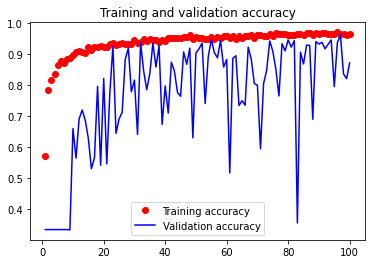

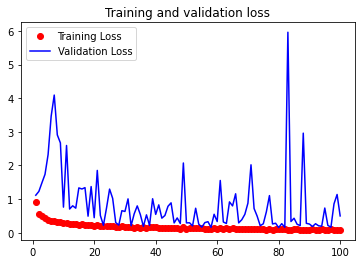

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_training(history6)

#### Testing

In [ ]:
testModel = keras.models.load_model('/content/AdvancedModel2.0.keras')
tLoss, tAcc, tPres, tRecall = testModel.evaluate(testDataset)
print(f'Test Accuracy:{tAcc:3f}')
print(f'Test Precission:{tPres:3f}')
print(f'Test Recall:{tRecall:3f}')

59/59 [==============================] - 3s 39ms/step - loss: 0.1599 - accuracy: 0.9509 - precision: 0.9569 - recall: 0.9477
Test Accuracy:0.950933
Test Precission:0.956920
Test Recall:0.947733


###Model 6.1: increasing filter size

In [ ]:

# define the model
model6 = Sequential()
model6.add(augmentation)
model6.add(Rescaling(1./255))

# add first convolutional layer since channels on images are highly correlated
model6.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model6.add(MaxPooling2D(pool_size=(2,2)))


for filters in [64,128,256]:

  model6.add(SeparableConv2D(filters,3,padding='same', activation='relu'))
  model6.add(SeparableConv2D(filters,3,padding='same',activation='relu'))

  model6.add(BatchNormalization())
  model6.add(MaxPooling2D(pool_size=(2,2)))
  model6.add(Dropout(0.2))

# Instead of using a flatten layer here we invoke GlobalAveragePooling2D
model6.add(GlobalAveragePooling2D())

model6.add(Dense(units=64, activation='relu'))
model6.add(Dropout(0.1))

model6.add(Dense(units=24, activation='relu'))
model6.add(Dropout(0.1))

## add the output layer

model6.add(Dense(units=3, activation='softmax'))

# compile the model
model6.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy', 'Precision','Recall'])

#### Training

In [ ]:
callbacks6_1 = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'AdvancedModel3.0.keras',
        save_best_only = True,
        monitor = 'val_loss'
    )
]

history6_1 = model6_1.fit(
    tDataset,
    epochs = 50,
    validation_data = vDataset,
    callbacks = callbacks6_1
)

Epoch 1/50
66/66 [==============================] - 24s 320ms/step - loss: 0.4512 - accuracy: 0.8414 - precision: 0.8812 - recall: 0.7805 - val_loss: 1.1153 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
66/66 [==============================] - 20s 293ms/step - loss: 0.2739 - accuracy: 0.9090 - precision: 0.9132 - recall: 0.9014 - val_loss: 1.1989 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
66/66 [==============================] - 19s 276ms/step - loss: 0.2399 - accuracy: 0.9162 - precision: 0.9191 - recall: 0.9143 - val_loss: 1.3838 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
66/66 [==============================] - 21s 318ms/step - loss: 0.2078 - accuracy: 0.9267 - precision: 0.9308 - recall: 0.9229 - val_loss: 1.7348 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 5/50
66/66 [==============================] - 19s 282ms/step - loss: 0

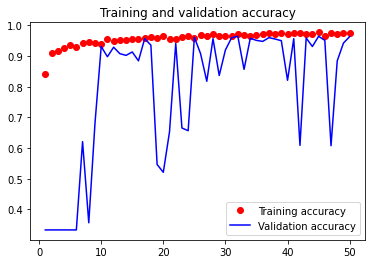

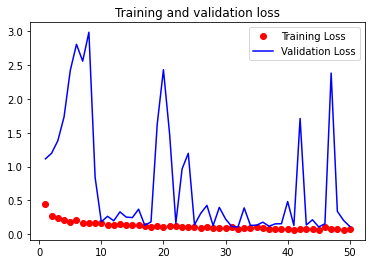

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_training(history6_1)

#### Testing

In [ ]:
testModel = keras.models.load_model('/content/AdvancedModel3.0.keras')
tLoss, tAcc, tPres, tRecall = testModel.evaluate(testDataset)
print(f'Test Accuracy:{tAcc:3f}')
print(f'Test Precission:{tPres:3f}')
print(f'Test Recall:{tRecall:3f}')

59/59 [==============================] - 3s 40ms/step - loss: 0.1385 - accuracy: 0.9589 - precision: 0.9594 - recall: 0.9589
Test Accuracy:0.958933
Test Precission:0.959445
Test Recall:0.958933


### Model 6.2: mini Xception model Using keras functional API in order to implement a residual connection


In [ ]:
inputs = keras.Input(shape=(180,180,3))
# For consistency we still invoke the same data augmentation module and rescalling
x = augmentation(inputs)
x = Rescaling(1/255)(x)

#Since RGB channels are highly correlated we first need to run an ordinary Conv2D 
x = Conv2D(filters=32, kernel_size = (3,3), use_bias = False)(x)
x = MaxPooling2D(3, strides=2, padding='same')(x)

# Using a for loop we create multiple blocks of depth wise separable convolutions
for filters in [32,64,128,256]:
  residual = x

  x = Activation('relu')(x)
  x = SeparableConv2D(filters, 3, padding='same', use_bias=False)(x)

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(filters, 3, padding='same', use_bias=False)(x)

  x = MaxPooling2D(3, strides=2, padding='same')(x)

  residual = Conv2D(filters, 1, strides=2, padding='same', use_bias=False)(residual)
  x = add([x,residual])

# Instead of using a flatten layer here we invoke GlobalAveragePooling2D
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)


outp = Dense(units = 3, activation='softmax')(x)
model6_2 = keras.Model(inputs=inputs, outputs=outp)

model6_2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'Precision','Recall'])

####Training

In [ ]:
callbacks6_2 = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'AdvancedModel4.0.keras',
        save_best_only = True,
        monitor = 'val_loss'
    )
]

history6_2 = model6_2.fit(
    tDataset,
    epochs = 100,
    validation_data = vDataset,
    callbacks = callbacks6_2
)

Epoch 1/100
66/66 [==============================] - 18s 214ms/step - loss: 0.8079 - accuracy: 0.6424 - precision: 0.7269 - recall: 0.4843 - val_loss: 1.2009 - val_accuracy: 0.3333 - val_precision: 0.4408 - val_recall: 0.2689
Epoch 2/100
66/66 [==============================] - 13s 198ms/step - loss: 0.5381 - accuracy: 0.7976 - precision: 0.8154 - recall: 0.7700 - val_loss: 1.1885 - val_accuracy: 0.3433 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
66/66 [==============================] - 13s 193ms/step - loss: 0.4189 - accuracy: 0.8486 - precision: 0.8564 - recall: 0.8376 - val_loss: 1.2911 - val_accuracy: 0.3644 - val_precision: 0.9286 - val_recall: 0.0289
Epoch 4/100
66/66 [==============================] - 13s 194ms/step - loss: 0.3477 - accuracy: 0.8757 - precision: 0.8810 - recall: 0.8705 - val_loss: 1.2605 - val_accuracy: 0.3333 - val_precision: 0.3522 - val_recall: 0.3322
Epoch 5/100
66/66 [==============================] - 13s 192ms/step - loss: 0.2927 - acc

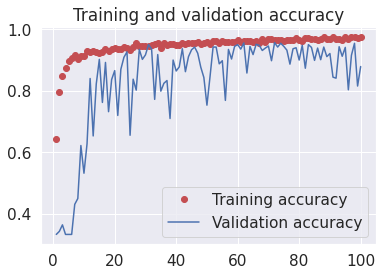

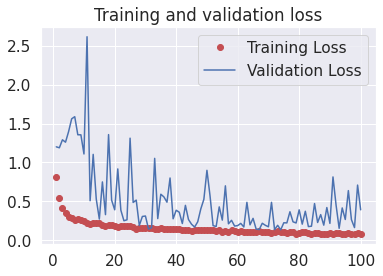

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_training(history6_2)

#### Testing

In [ ]:
testModel = keras.models.load_model('/content/AdvancedModel4.0.keras')
tLoss, tAcc, tPres, tRecall = testModel.evaluate(testDataset)
print(f'Test Accuracy:{tAcc:3f}')
print(f'Test Precission:{tPres:3f}')
print(f'Test Recall:{tRecall:3f}')

59/59 [==============================] - 4s 47ms/step - loss: 0.1549 - accuracy: 0.9557 - precision: 0.9572 - recall: 0.9541
Test Accuracy:0.955733
Test Precission:0.957196
Test Recall:0.954133


In [ ]:
model6_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_2[0][0]']                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 180, 180, 3)  0           ['sequential[1][0]']             
                                                                                                  
 conv2d_6 (Conv2D)              (None, 178, 178, 32  864         ['rescaling_2[0][0]']      

###Model: 6.3 adding Max Pooling layers to improve efficiency.

In [ ]:
inputs = keras.Input(shape=(180,180,3))
# For consistency we still invoke the same data augmentation module and rescalling
x = augmentation(inputs)
x = Rescaling(1/255)(x)

#Since RGB channels are highly correlated we first need to run an ordinary Conv2D 
x = Conv2D(filters=32, kernel_size = (3,3), use_bias = False)(x)

for filters in [32,64,128,256]:
  residual = x

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(filters, 3, padding='same', use_bias=False)(x)

  #we add another max pooling layer between each block
  x = MaxPooling2D((2,2), strides=2, padding='same')(x)

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(filters, 3, padding='same', use_bias=False)(x)
  
  x = MaxPooling2D(3, strides=2, padding='same')(x)

  residual = Conv2D(filters, 1, strides=2, padding='same', use_bias=False)(residual)
  
  # And another maxpooling layer after the residuals have been updated
  residual = MaxPooling2D((2,2), strides=2, padding='same')(residual)

  x = add([x,residual])

x = Flatten()(x)
x = Dropout(0.4)(x)

outp = Dense(units = 3, activation='softmax')(x)
model6_3 = keras.Model(inputs=inputs, outputs=outp)

model6_3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'Precision','Recall'])

#### Training

In [ ]:
callbacks6_3 = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'AdvancedModel5.0.keras',
        save_best_only = True,
        monitor = 'val_loss'
    )
]

history6_3 = model6_3.fit(
    tDataset,
    epochs = 100,
    validation_data = vDataset,
    callbacks = callbacks6_3
)

Epoch 1/100
66/66 [==============================] - 31s 268ms/step - loss: 0.6504 - accuracy: 0.7390 - precision: 0.7944 - recall: 0.6533 - val_loss: 1.1304 - val_accuracy: 0.3333 - val_precision: 0.4086 - val_recall: 0.3078
Epoch 2/100
66/66 [==============================] - 17s 247ms/step - loss: 0.3435 - accuracy: 0.8738 - precision: 0.8794 - recall: 0.8643 - val_loss: 1.1059 - val_accuracy: 0.3311 - val_precision: 0.5010 - val_recall: 0.2844
Epoch 3/100
66/66 [==============================] - 17s 248ms/step - loss: 0.2601 - accuracy: 0.9019 - precision: 0.9068 - recall: 0.8986 - val_loss: 1.2285 - val_accuracy: 0.3333 - val_precision: 0.3384 - val_recall: 0.3222
Epoch 4/100
66/66 [==============================] - 17s 246ms/step - loss: 0.2446 - accuracy: 0.9186 - precision: 0.9236 - recall: 0.9148 - val_loss: 1.1787 - val_accuracy: 0.4578 - val_precision: 0.5877 - val_recall: 0.3089
Epoch 5/100
66/66 [==============================] - 17s 249ms/step - loss: 0.2040 - accuracy: 0

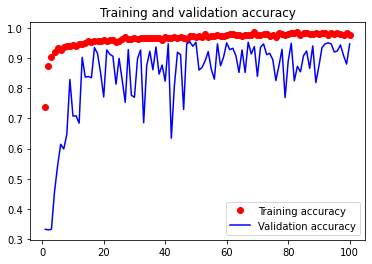

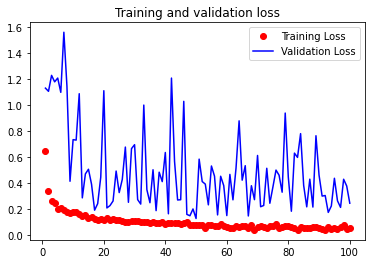

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_training(history6_3)

#### Testing

In [ ]:
testModel = keras.models.load_model('/content/AdvancedModel5.0.keras')
tLoss, tAcc, tPres, tRecall = testModel.evaluate(testDataset)
print(f'Test Accuracy:{tAcc:3f}')
print(f'Test Precission:{tPres:3f}')
print(f'Test Recall:{tRecall:3f}')

59/59 [==============================] - 3s 46ms/step - loss: 0.1358 - accuracy: 0.9589 - precision: 0.9594 - recall: 0.9589
Test Accuracy:0.958933
Test Precission:0.959445
Test Recall:0.958933


### Model 6.4 adding Dense layers before output

In [ ]:
inputs = keras.Input(shape=(180,180,3))
# For consistency we still invoke the same data augmentation module and rescalling
x = augmentation(inputs)
x = Rescaling(1/255)(x)

#Since RGB channels are highly correlated we first need to run an ordinary Conv2D 
x = Conv2D(filters=32, kernel_size = (3,3), use_bias = False)(x)

for filters in [32,64,128,256]:
  residual = x

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(filters, 3, padding='same', use_bias=False)(x)

  #we add another max pooling layer between each block
  x = MaxPooling2D((2,2), strides=2, padding='same')(x)

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(filters, 3, padding='same', use_bias=False)(x)
  
  x = MaxPooling2D(3, strides=2, padding='same')(x)

  residual = Conv2D(filters, 1, strides=2, padding='same', use_bias=False)(residual)
  
  # And another maxpooling layer after the residuals have been updated
  residual = MaxPooling2D((2,2), strides=2, padding='same')(residual)

  x = add([x,residual])

x = Flatten()(x)
x = Dropout(0.4)(x)

x = Dense(48,activation="relu")(x)
x = Dense(18,activation="relu")(x)

outp = Dense(units = 3, activation='softmax')(x)
model6_4 = keras.Model(inputs=inputs, outputs=outp)

model6_4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'Precision','Recall'])

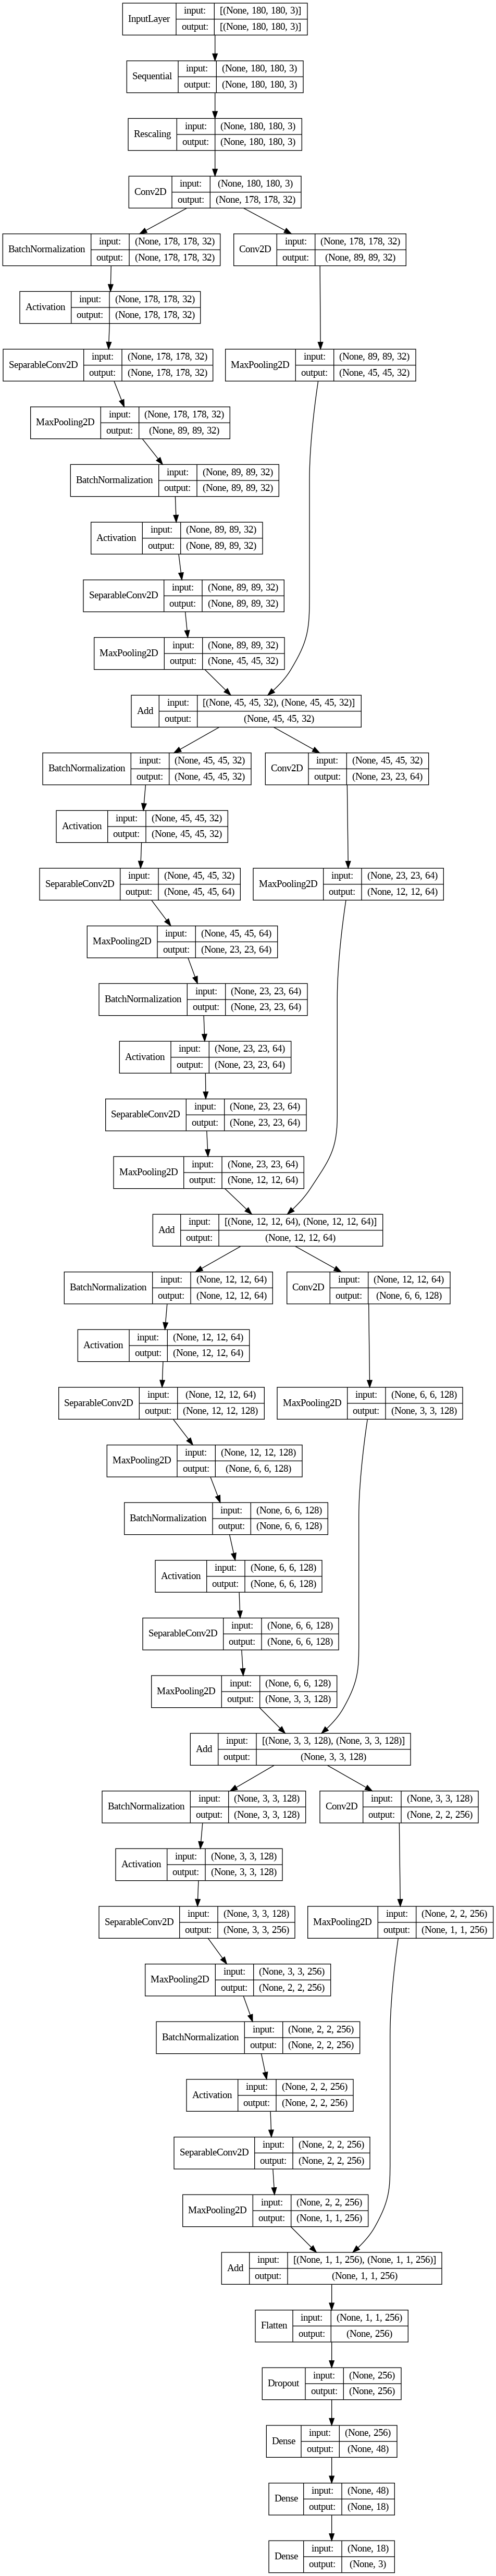

In [ ]:
# we plot our model's architecture to better visualize it 
from keras.utils.vis_utils import plot_model
plot_model(model6_4, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
model6_4.summary(
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 178, 178, 32  864         ['rescaling[0][0]']          

#### Training

In [ ]:
callbacks6_4 = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'AdvancedModel6.0.keras',
        save_best_only = True,
        monitor = 'val_loss'
    )
]

history6_4 = model6_4.fit(
    tDataset,
    epochs = 200,
    validation_data = vDataset,
    callbacks = callbacks6_4
)

Epoch 1/200
66/66 [==============================] - 28s 323ms/step - loss: 0.7882 - accuracy: 0.6524 - precision: 0.7419 - recall: 0.5105 - val_loss: 1.4163 - val_accuracy: 0.3333 - val_precision: 0.3315 - val_recall: 0.3278
Epoch 2/200
66/66 [==============================] - 19s 286ms/step - loss: 0.4389 - accuracy: 0.8371 - precision: 0.8549 - recall: 0.8190 - val_loss: 1.6559 - val_accuracy: 0.3333 - val_precision: 0.3322 - val_recall: 0.3311
Epoch 3/200
66/66 [==============================] - 20s 297ms/step - loss: 0.3314 - accuracy: 0.8833 - precision: 0.8875 - recall: 0.8719 - val_loss: 1.1749 - val_accuracy: 0.3278 - val_precision: 0.3875 - val_recall: 0.3022
Epoch 4/200
66/66 [==============================] - 19s 289ms/step - loss: 0.2835 - accuracy: 0.9000 - precision: 0.9045 - recall: 0.8971 - val_loss: 1.3598 - val_accuracy: 0.3656 - val_precision: 0.3759 - val_recall: 0.3300
Epoch 5/200
66/66 [==============================] - 20s 296ms/step - loss: 0.2529 - accuracy: 0

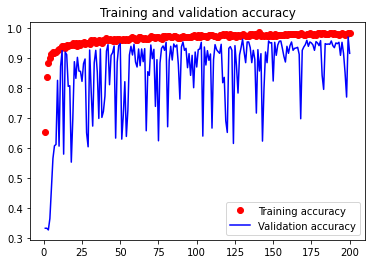

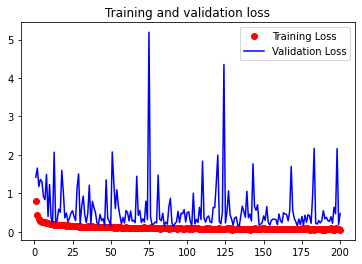

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_training(history6_4)

#### Testing

In [ ]:
testModel = keras.models.load_model('/content/AdvancedModel6.0.keras')
tLoss, tAcc, tPres, tRecall = testModel.evaluate(testDataset)
print(f'Test Accuracy:{tAcc:3f}')
print(f'Test Precission:{tPres:3f}')
print(f'Test Recall:{tRecall:3f}')

59/59 [==============================] - 3s 40ms/step - loss: 0.1453 - accuracy: 0.9589 - precision: 0.9594 - recall: 0.9579
Test Accuracy:0.958933
Test Precission:0.959402
Test Recall:0.957867


In [ ]:
true_categories = tf.concat([y for x, y in testDataset], axis=0)

In [ ]:
# Variables for storing all the labels
y_true = []
y_pred = []

#iterate through dataset and append the relevant values to the variables specified above
for x,y in testDataset:
  y= tf.argmax(y,axis=1)
  y_true.append(y)
  y_pred.append(tf.argmax(testModel.predict(x),axis = 1))

# concatenate them into a tensor object 
y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)

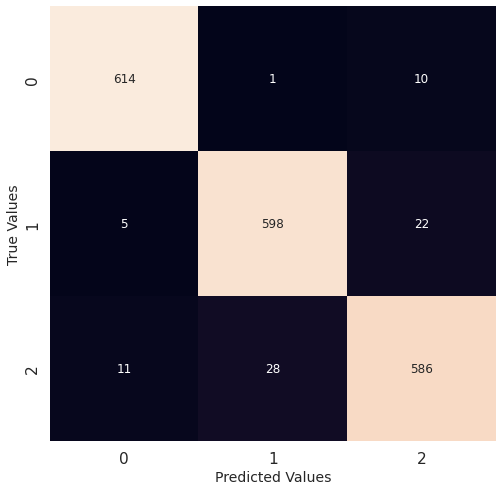

In [ ]:
#specify confusion matrix 
cm = confusion_matrix(y_true, y_pred)

#specify size and subplots
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)

#employ seaborn heatmap 
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False,fmt='1');

#define axis labels 
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
plt.show()

# 8.Model 7 Stripping Down complexity and putting it all together

In [ ]:
from tensorflow.keras.layers import BatchNormalization

# define the model
model7 = Sequential()
model7.add(augmentation)
model7.add(Rescaling(1./255))

# add first convolutional block since channels on images are highly correlated
model7.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2,2)))

# Then stack together three separable Convolution Blocks with batch normalization and max pooling
model7.add(SeparableConv2D(filters=128, kernel_size=(3,3), activation='relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2,2)))

model7.add(SeparableConv2D(filters=256, kernel_size=(3,3), activation='relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2,2)))

model7.add(SeparableConv2D(filters=512, kernel_size=(3,3), activation='relu'))

model7.add(MaxPooling2D(pool_size=(2,2)))

# add a flattening layer and Dropout
model7.add(Flatten())
model7.add(Dropout(0.4))

# densly connected layers are stacked to form our classifier,
model7.add(Dense(48,activation="relu"))
model7.add(Dense(24,activation="relu"))
model7.add(Dense(6,activation="relu"))

model7.add(BatchNormalization())

#  output layer, since we’ll do multinomial classification we end the model with a Dense layer of three units and softmax activation
model7.add(Dense(units=3, activation='softmax'))

# compile the model
model7.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy', 'Precision','Recall'])

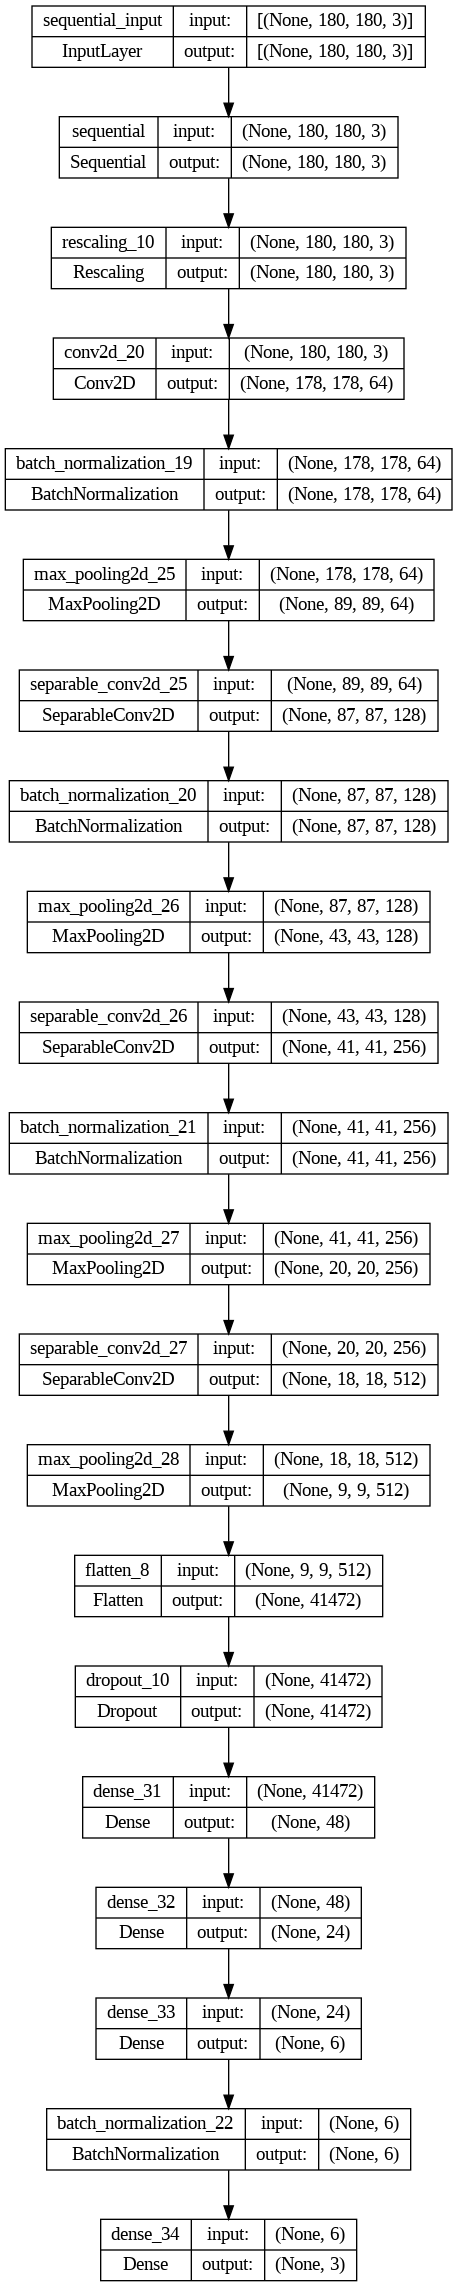

In [ ]:
# we plot the architeccture to better visualize it 
plot_model(testModel, to_file='model7_plot.png', show_shapes=True, show_layer_names=False)

#### Training

In [ ]:
callbacks7 = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'AdvancedModel7.0.keras',
        save_best_only = True,
        monitor = 'val_loss'
    )
]

history7 = model7.fit(
    tDataset,
    epochs = 100,
    validation_data = vDataset,
    callbacks = callbacks7
)


Epoch 1/100
66/66 [==============================] - 22s 286ms/step - loss: 0.5723 - accuracy: 0.8290 - precision: 0.8789 - recall: 0.7295 - val_loss: 1.4303 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 2/100
66/66 [==============================] - 14s 203ms/step - loss: 0.4201 - accuracy: 0.8990 - precision: 0.9314 - recall: 0.8467 - val_loss: 1.8934 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 3/100
66/66 [==============================] - 13s 200ms/step - loss: 0.3609 - accuracy: 0.9100 - precision: 0.9344 - recall: 0.8819 - val_loss: 2.0048 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 4/100
66/66 [==============================] - 14s 202ms/step - loss: 0.3100 - accuracy: 0.9167 - precision: 0.9330 - recall: 0.8957 - val_loss: 1.9899 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 5/100
66/66 [==============================] - 14s 207ms/step - loss: 0.2889 - accuracy: 0

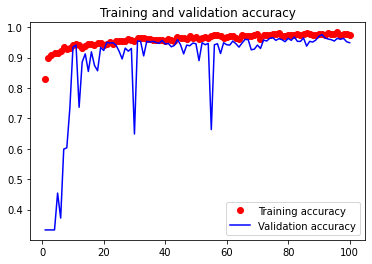

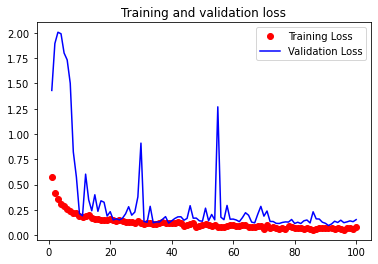

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_training(history7)

#### Testing

In [ ]:
testModel = keras.models.load_model('/content/AdvancedModel7.0.keras')
tLoss, tAcc, tPres, tRecall = testModel.evaluate(testDataset)
print(f'Test Accuracy:{tAcc:3f}')
print(f'Test Precission:{tPres:3f}')
print(f'Test Recall:{tRecall:3f}')

59/59 [==============================] - 3s 41ms/step - loss: 0.1046 - accuracy: 0.9659 - precision: 0.9664 - recall: 0.9659
Test Accuracy:0.965867
Test Precission:0.966382
Test Recall:0.965867


In [ ]:
files.download('/content/AdvancedModel7.0.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Building a Confusion Matrix 

In [ ]:
# Variables for storing all the labels
y_true = []
y_pred = []

#iterate through dataset and append the relevant values to the variables specified above
for x,y in testDataset:
  y= tf.argmax(y,axis=1)
  y_true.append(y)
  y_pred.append(tf.argmax(testModel.predict(x),axis = 1))

# concatenate them into a tensor object 
y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)

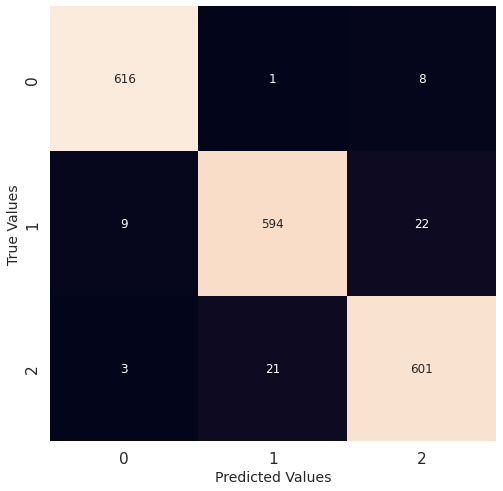

In [ ]:
#specify confusion matrix 
cm = confusion_matrix(y_true, y_pred)

#specify size and subplots
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)

#employ seaborn heatmap 
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False,fmt='1');
#define labels 
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
plt.show()

In [ ]:
testModel.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 178, 178, 64)      1792      
                                                                 
 batch_normalization_19 (Bat  (None, 178, 178, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 89, 89, 64)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_25 (Separa  (None, 87, 87, 128)    

# 9.Auto Hyperparameter Optimization

After evaluating all of our models, we see that fine tuning a very advanced architecture as EfficientNet2 yields the best results overall at 0.968466 test precision. However, a much simpler model using combining diferent techniques suchs as separable convolutions and batch normalization like the one we trained above yield very similar results (Test Precission:0.966382).

Hence we will implement auto hyperparameter optimization on this model to try to further improve its performance.

To do this we will use Keras Tuner. The createModel function, defined below, takes a single object, hp, as its input. This is the hyperparameter tuning object from Keras Tuner that we will define later.

Inside we will specify the different parameters we aim to test with different values by invoking the hp object.

### Define Hypermodel

In [ ]:

def createModel(hp):

  model = Sequential()
  model.add(augmentation)
  model.add(Rescaling(1./255))

  # add first convolutional block since channels on images are highly correlated
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))

  #Specify first hyperparameter to search over, it is the number of filters of our first separable convolution
  SConv1 = hp.Int('Sconv-1', min_value=32, max_value=96, step=32)

  # First Separable Convolution Block > BatchNormalization > MaxPooling
  model.add(SeparableConv2D(SConv1, 3,padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))

  SConv2 = hp.Int("Sconv-2", min_value=128, max_value=256, step=64)

  # Second Separable Convolution Block > BatchNormalization > MaxPooling
  model.add(SeparableConv2D(SConv2, 3,padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))

  SConv3 = hp.Int("Sconv-3", min_value=256, max_value=512, step=128)

  # Third Separable Convolution Block > MaxPooling
  model.add(SeparableConv2D(SConv3, 3,padding='same',activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='same'))

  # We revert back to a flatten layer and use Dropout for normalization
  model.add(Flatten())

  model.add(Dropout(0.5))

  # Stack of densly connected layers to form our classifier
  model.add(Dense(48,activation="relu"))
  model.add(Dense(24,activation="relu"))
  model.add(Dense(6,activation="relu"))

  model.add(BatchNormalization())

  ## Output layer
  model.add(Dense(units=3, activation='softmax'))

  # Search over optimizers 
  optzr = hp.Choice(name='optimizer', values=['rmsprop','adam'])

  # compile the model and return it
  model.compile(loss='categorical_crossentropy', optimizer=optzr, metrics=['accuracy', 'Precision','Recall'])
  return model

Now we define our keras tuner, in this case we will use Bayesian Optimization. We pass the hypermodel function we defined above as an argument and define the objective to which the tuner will try to optimize, in our case, maximum validation precision.

### Invoking Keras tuner

In [ ]:
tuner = kt.BayesianOptimization(
    createModel,
    objective= kt.Objective('val_precision', direction='max'),
    max_trials = 30,
    executions_per_trial=2,
    directory="kt_test",
    overwrite=True
)

In [ ]:
callbacks8 = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)
]

history8 = tuner.search(
        tDataset,
        epochs = 50,
        batch_size = 128,
        validation_data = vDataset,
        callbacks = callbacks8,
        verbose = 2
    )

In [ ]:
bestHyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("[INFO] optimal number of filters in Sconv-1 layer: {}".format(
	bestHyperparameters.get("Sconv-1")))
print("[INFO] optimal number of filters in Sconv-2 layer: {}".format(
	bestHyperparameters.get("Sconv-2")))
print("[INFO] optimal number of filters in Sconv-3 layer: {}".format(
	bestHyperparameters.get("Sconv-3")))
print("[INFO] optimal optimizer : {}".format(
	bestHyperparameters.get("optimizer")))

[INFO] optimal number of filters in Sconv-1 layer: 96
[INFO] optimal number of filters in Sconv-2 layer: 192
[INFO] optimal number of filters in Sconv-3 layer: 256
[INFO] optimal optimizer : rmsprop


Based on our aproximated optimal hyperparameters we proceed to create a new model 

### Compiling & Training the Model with best found parameters 

In [ ]:
model8 = tuner.hypermodel.build(bestHyperparameters)

callbacks8 = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'AHO_model.keras',
        save_best_only = True,
        monitor = ('val_loss')
    )
]

history8 = model8.fit(
    tDataset,
    epochs = 100,
    validation_data = vDataset,
    callbacks = callbacks8
)

Epoch 1/100
66/66 [==============================] - 19s 208ms/step - loss: 0.7231 - accuracy: 0.7143 - precision: 0.8053 - recall: 0.4748 - val_loss: 1.3987 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 2/100
66/66 [==============================] - 14s 204ms/step - loss: 0.5283 - accuracy: 0.8362 - precision: 0.8852 - recall: 0.7162 - val_loss: 1.9693 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 3/100
66/66 [==============================] - 14s 201ms/step - loss: 0.4461 - accuracy: 0.8805 - precision: 0.9148 - recall: 0.8338 - val_loss: 2.0740 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 4/100
66/66 [==============================] - 18s 263ms/step - loss: 0.3754 - accuracy: 0.8929 - precision: 0.9225 - recall: 0.8671 - val_loss: 2.0798 - val_accuracy: 0.3333 - val_precision: 0.3333 - val_recall: 0.3333
Epoch 5/100
66/66 [==============================] - 16s 234ms/step - loss: 0.3517 - accuracy: 0

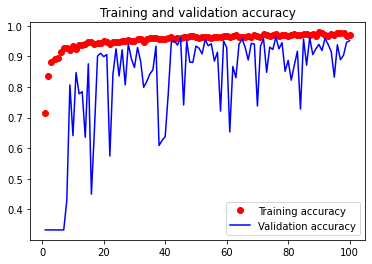

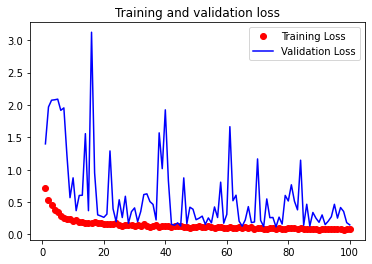

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_training(history8)

### Testing 

In [ ]:
testModel = keras.models.load_model('/content/AHO_model.keras')
tLoss, tAcc, tPres, tRecall = testModel.evaluate(testDataset)
print(f'Test Accuracy:{tAcc:3f}')
print(f'Test Precission:{tPres:3f}')
print(f'Test Recall:{tRecall:3f}')

59/59 [==============================] - 11s 59ms/step - loss: 0.1035 - accuracy: 0.9616 - precision: 0.9636 - recall: 0.9611
Test Accuracy:0.961600
Test Precission:0.963636
Test Recall:0.961067


In [ ]:
files.download('/content/AHO_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 10.Evaluation

After analysing all different models, we move into throughly testing Model 7 which was our the performer model of our own, in order to validate the results.

We will perform cross dataset validation as well as k-fold cross validation

### 10.1 Cross Dataset Validation

To perform Cross Dataset validation, we will use our secondary dataset we downloaded earlier. It is the Chest X-ray (Covid-19 & Pneumonia) from kaggle, which consists of 6432 X-Ray images for the same three categories as our original Dataset (i.e: Normal, Covid-19, Pneumonia)

Since we will only use this dataset for cross validating our model, we will use it in its entirety without doing any splitting. 


#### Consolidating the Data

We repeatedly apply the split folder operation updating the original directory in order to consolidate all the images in a single folder, with subfolders for each category, since our dataset comes pre splitted in training and testing subsets.

In [ ]:
originalDir2 = pathlib.Path("/content/Data/test")
newDir2 = pathlib.Path("CovidDataset2")  

In [ ]:
splitfolders.ratio(originalDir2,
                    output= newDir2,
                    seed=42, 
                    ratio=(1,0,0), 
                    group_prefix=None, 
                    move=False) 

Copying files: 1288 files [00:01, 785.88 files/s] 


In [ ]:
originalDir3 = pathlib.Path("/content/Data/train")

In [ ]:
splitfolders.ratio(originalDir3,
                    output= newDir2,
                    seed=42, 
                    ratio=(1,0,0), 
                    group_prefix=None, 
                    move=False) 

Copying files: 5144 files [00:06, 797.89 files/s] 


After doing so, we remove unnecesary folders to make everything cleaner and easier to understand by invoking rmtree

In [ ]:
shutil.rmtree('CovidDataset2/test')	
shutil.rmtree('CovidDataset2/val')	

Finally we proceed to create our dataset using the images and test the model. We can see that we have a total of 6432 images for our cross dataset validation.

In [ ]:
CrossValDataset = image_dataset_from_directory('/content/CovidDataset2/train', image_size=(180,180), batch_size=32, label_mode = 'categorical')

Found 6432 files belonging to 3 classes.


#### Testing & Results

In [ ]:
testModel = keras.models.load_model('/content/AHO_model.keras')

In [ ]:
tLoss, tAcc, tPres, tRecall = testModel.evaluate(CrossValDataset)
print(f'Test Accuracy:{tAcc:3f}')
print(f'Test Precission:{tPres:3f}')
print(f'Test Recall:{tRecall:3f}')


201/201 [==============================] - 64s 273ms/step - loss: 0.1815 - accuracy: 0.9400 - precision: 0.9426 - recall: 0.9395
Test Accuracy:0.939988
Test Precission:0.942599
Test Recall:0.939521


We can see that the model can achieve an only slightly worse performance on a different dataset of unseen images. Below we plot the confusion matrix and sklearn classification report for more clarity on the performance of the model.

#### Confusion Matrix

In [ ]:
y_true = []
y_pred = []
for x,y in CrossValDataset:
  y= tf.argmax(y,axis=1)
  y_true.append(y)
  y_pred.append(tf.argmax(testModel.predict(x),axis = 1))
  
y_pred = tf.concat(y_pred, axis=0)
y_true = tf.concat(y_true, axis=0)

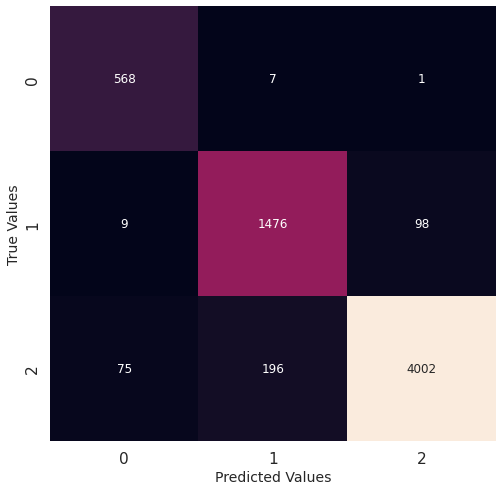

In [ ]:
cm = confusion_matrix(y_true, y_pred)
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False,fmt='1');
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
plt.show()

#### Classification Report

In [ ]:
print(classification_report(y_true,y_pred,target_names=['0 Covid', '1 Pneumonia', '2 Normal']))


              precision    recall  f1-score   support

     0 Covid       0.87      0.99      0.93       576
 1 Pneumonia       0.88      0.93      0.90      1583
    2 Normal       0.98      0.94      0.96      4273

    accuracy                           0.94      6432
   macro avg       0.91      0.95      0.93      6432
weighted avg       0.94      0.94      0.94      6432



### 10.2 K-Fold Cross Validation

In [ ]:
dataPath = pathlib.Path(newDir)

imgPath = list(dataPath.glob("**/*.png"))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], imgPath))

We will use a pandas **dataframe** to compile the path and label of each image with the following code

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


pdImg = pd.Series(imgPath, name='Path').astype(str)
pdLabels = pd.Series(labels, name='Labels').astype(str)

df = pd.merge(pdImg, pdLabels, right_index=True, left_index=True)

df = df.sample(frac = 1).reset_index(drop=True)
df.head()

,Path,Labels
0,CovidDataset1/test/COVID/COVID_1016.png,COVID
1,CovidDataset1/val/NORMAL/NORMAL_51.png,NORMAL
2,CovidDataset1/train/PNEUMONIA/PNEUMONIA_346.png,PNEUMONIA
3,CovidDataset1/train/COVID/COVID_131.png,COVID
4,CovidDataset1/train/NORMAL/NORMAL_588.png,NORMAL


To make sure everything works appropiately we will plot some of the images and their labels.

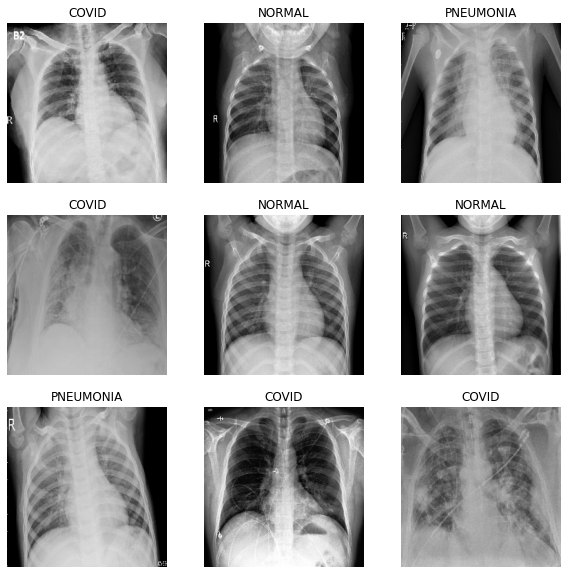

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(plt.imread(df.Path[i]))
  plt.title(df.Labels[i])
  plt.axis("off")

In [ ]:
trainDataset, test_dataset = train_test_split (df, train_size=0.9, shuffle=True, stratify=df['Labels'])

width = 180
height = 180

datagen = ImageDataGenerator(validation_split=0.2)

In [ ]:
kFoldModel = model7
epochs = 50

lossScores = []
accuracyScores = []
precisionScores = []
recallScores = []

kfold = KFold(3, shuffle=True, random_state =123)

In [ ]:
for f, (trI, valI) in enumerate (kfold.split(trainDataset)):
  print(); print("+"*60)
  print("Fold Number: ",f+1)
  print("+"*60)

  kFoldModel = model7

  train_ds = datagen.flow_from_dataframe(df.loc[trI,:], 
                                         x_col='Path', y_col='Labels',
                                         target_size=(width,height),
                                         class_mode = 'categorical', color_mode = 'rgb',
                                         shuffle = True)
  
  test_ds = datagen.flow_from_dataframe(df.loc[valI,:], 
                                       x_col='Path', y_col='Labels',
                                       target_size=(width,height),
                                       class_mode = 'categorical', color_mode = 'rgb'
                                       , shuffle = True)
  
  fold_start_epoch = f * epochs
  fold_end_epoch = epochs * (f+1)
  
  history=kFoldModel.fit(train_ds, initial_epoch=fold_start_epoch , epochs=fold_end_epoch, 
                    shuffle=True)
  
  tLoss, tAcc, tPres, tRecall = kFoldModel.evaluate(test_ds)
  
  # store history A for each folds
  lossScores.append(tLoss)
  accuracyScores.append(tAcc)
  precisionScores.append(tPres)
  recallScores.append(tRecall)


  # Define start and end epoch for each folds
  fold_start_epoch = f * epochs
  fold_end_epoch = epochs * (f+1)
  


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Fold Number:  1
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Found 2924 validated image filenames belonging to 3 classes.
Found 1463 validated image filenames belonging to 3 classes.
Epoch 1/50


92/92 [==============================] - 47s 276ms/step - loss: 0.6947 - accuracy: 0.8523 - precision: 0.9337 - recall: 0.5876
Epoch 2/50
92/92 [==============================] - 25s 276ms/step - loss: 0.5096 - accuracy: 0.9111 - precision: 0.9541 - recall: 0.8177
Epoch 3/50
92/92 [==============================] - 26s 278ms/step - loss: 0.3977 - accuracy: 0.9248 - precision: 0.9485 - recall: 0.8878
Epoch 4/50
92/92 [==============================] - 25s 271ms/step - loss: 0.3185 - accuracy: 0.9340 - precision: 0.9501 - recall: 0.9111
Epoch 5/50
92/92 [==============================] - 25s 271ms/step - loss: 0.2641 - accuracy: 0.9357 - precision: 0.9503 - recall: 0.9217
Epoch 6/50
92/92 [==============================] - 25s 272ms/step - loss: 0.2241 - accuracy: 0.9436 - precision: 0.9510 - recall: 0.9350
Epoch 7/50
92/92 [==============================] - 25s 272ms/step - loss: 0.1954 - accuracy: 0.9456 - precision: 0.9522 - recall: 0.9398
Epoch 8/50
92/92 [===========================

In [ ]:
from statistics import mean
lossScoresAvg= mean(lossScores)
print(f'Avg Loss:{lossScoresAvg}')

accuracyScoresAvg= mean(accuracyScores)
print(f'Avg Accuracy:{accuracyScoresAvg}')

precisionScoresAvg= mean(precisionScores)
print(f'Avg Precision:{precisionScoresAvg}')

recallScoresAvg= mean(recallScores)
print(f'Avg Recall:{recallScoresAvg}')

Avg Loss:1.2670262058575947
Avg Accuracy:0.6986481348673502
Avg Precision:0.700882613658905
Avg Recall:0.6961410840352377
